# This notebook is for interpreting map-matching results and calculating traffic speed

In [1]:
import os
import geopandas as gpd
# from shapely.geometry import LineString
import pandas as pd
import numpy as np
import shapely
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt
from shapely import wkt
from platform import python_version
print(python_version())
print(python_version())
print(f"geopandas version: {gpd.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"shapely version: {shapely.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

3.9.12
3.9.12
geopandas version: 0.11.0
pandas version: 1.4.3
numpy version: 1.22.4
shapely version: 1.8.2
matplotlib version: 3.5.1


In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings(action='ignore', category=pd.errors.PerformanceWarning)

# 0 Set key paths

In [26]:
mmgps_dir = '../data/map_matching_data/gps'
mrdir = '../data/map_matching_data/mmresult'
sp_dir = '../output'

In [27]:
datedir_ls = []
for root, dirs, files in os.walk(mrdir):
#     print(dirs)
    for d in dirs:
        datedir_ls.append(d)
        
len(datedir_ls), datedir_ls

(1, ['2021-05-02'])

In [28]:
road=gpd.read_file(r'../data/map_matching_data/road/TomTomRoad2021_2326_seg_demo.shp')
road['id'] = '_'+road['linkID'].astype(str)+road['VAL_DIR'].astype(str)+road['SEG_SEQ'].astype(str)

In [15]:
road.shape

(14385, 11)

In [16]:
road.head()

,linkID,VAL_DIR,SEG_SEQ,source,target,NAME,ONEWAY,Shape_Leng,EDIT,id,geometry
0,13440001065581,3,00,13440003382090,13440003414415,花圃街,B,64.475668,DUP,_13440001065581300,"LINESTRING (836205.842 821527.835, 836200.176 ..."
1,13440001074604,3,00,13440003445250,13440003445249,南昌街,B,64.091434,DUP,_13440001074604300,"LINESTRING (835120.390 821432.966, 835117.732 ..."
2,13440001074614,3,00,13440003373214,13440003437847,福榮街,B,97.860617,DUP,_13440001074614300,"LINESTRING (835156.561 821151.376, 835081.875 ..."
3,13440001074716,3,00,13440003373214,13440003450121,福榮街,B,76.271960,DUP,_13440001074716300,"LINESTRING (835156.561 821151.376, 835201.733 ..."
4,13440001093269,3,00,13440003379967,13440003379966,培德街,B,97.812135,DUP,_13440001093269300,"LINESTRING (835091.827 821765.505, 835060.388 ..."


# 1 Function of calculating speed

In [29]:
# For calculating realtime speed for each trajectory (for each trjid)

def RealtimeSpeedEstimation(gps_matched_out, cpath_out, trjid):

    gps_matched_out['GPSID']=range(gps_matched_out.shape[0])
    gps_matched_out['DateTime'] = pd.to_datetime(gps_matched_out['DateTime'])

    t = gps_matched_out.set_index('DateTime')

    # temp = t.groupby(pd.Grouper(freq = '5Min'), as_index=False).apply(lambda x: x['Speed'])

    # gps_matched_out['t'] = pd.to_datetime(gps_matched_out['DateTime'] ).dt.time

    gps_matched_out['t'] = (gps_matched_out['DateTime'].dt.hour*3600+gps_matched_out['DateTime'].dt.minute*60)//300*300

    # Calculate road-level speed (by Huang Guan)
    df1 = cpath_out[['id','Shape_Leng']]

    df2 = gps_matched_out[['opath','Speed','t','DateTime','GPSID']]

    df2 = df2.rename(columns={'opath':'id','Speed':'v'})

    # df2['id'] = '_'+df2['id'].astype(str)

    df2 = df2.groupby([(df2['id'].shift() != df2['id']).cumsum(),'t']).agg({'v':'mean','DateTime':'first','id':'first','GPSID':'count'})

    df2 = df2[['id','v','DateTime','GPSID']]

    df2.columns=[['id_raw','v','DateTime','GPSID']]

    df2 = df2.reset_index([0,1]).drop('id',axis=1)

    df2.columns=[['t','id','v','DateTime','GPSID']]

    i=0
    j=0
    consequence_missing = 0
    consequence_duration = 0
    result = []

    while i < df2.shape[0]-1:
        # print(i)
        right_id = df2.loc[i,'id'].values[0]
        df1_temp = df1.loc[i+j:]
        for k in range(df1_temp.shape[0]):
            left_id = df1_temp.values[k, 0]
            if left_id == right_id:
                # print('same id', left_id,right_id,i, j,k)
                if consequence_missing>0:
                    consequence_duration2 = df2.loc[i,'DateTime']
                    duration = int((consequence_duration2-consequence_duration).dt.total_seconds())
                    consequence_duration = consequence_duration2
                    sum_len = 0
                    for m in range(consequence_missing):
                        sum_len += result[-1-m][2]
                    for m in range(consequence_missing):
                        result[-1-m][2] = (sum_len/duration)*3.6  # for road segments that are not directly matched to a GPS point, get the speed (km/h) based on distance and duration traveled

                    consequence_missing=0
                else:
                    consequence_duration = df2.loc[i,'DateTime']
                result.append(df2.loc[i,:].to_list())
                right_id_next = df2.loc[i + 1, 'id'].values[0]
                if right_id_next == right_id:
                    j -=1
                i += 1
                break
            else:
                # print('seg without gps', left_id, right_id, i, j, k)
                result.append([np.nan,left_id,df1_temp.values[k, 1],np.nan])
                j+=1
                consequence_missing+=1

    if df1_temp.values[k+1, 0]==df2.iloc[-1]['id']:
        result.append(df2.iloc[-1].values)
    else:
        len_lastrows=0
        for idx,row in df1_temp.iloc[k+1:].iterrows():
            len_lastrows+=row['Shape_Leng']
            result.append([np.nan,row['id'],row['Shape_Leng'],np.nan])

        consequence_duration2 = df2.loc[i,'DateTime']
        duration = int((consequence_duration2-consequence_duration).dt.total_seconds())
        for x in range(-1*(df1_temp.shape[0]-k-1),0):
            result[x][2] = (len_lastrows/duration)*3.6
            
    # result_df is the road-level speed estimation for the specific gps trajectory
    result_df = pd.DataFrame(result,columns=['t','id','v','DateTime','GPSID'])

    result_df['t']=result_df['t'].fillna(method='ffill')

    result_df['trjid']=str(trjid)

    return result_df

# 2 Interpret map-matching results and calculate speed

stmatch_{date}_demo.txt is the result file after running the map-matching algorithm. Meaning of ouput columns can be found here: https://fmm-wiki.github.io/docs/documentation/output


In [21]:
mrdir+'/stmatch_{}_demo.txt'.format(date)

'../data/map_matching_data/mmresult/stmatch_stmatch_2021-05-02_demo.txt_demo.txt'

In [25]:
date

'stmatch_2021-05-02_demo.txt'

In [24]:
mmgps_dir+'/gps_trj_{}_demo.csv'.format(date)

'../data/map_matching_data/gps/gps_trj_stmatch_2021-05-02_demo.txt_demo.csv'

In [32]:
''' Output the gps matching info and road traversed (IN USE!!!) '''

gps_matched_ct_df_all=pd.DataFrame()

for date in datedir_ls:
    print(date)
    
    if not os.path.exists(sp_dir+'/'+date):
        print('not estimated')
        
        if len(os.listdir(os.path.join(mrdir,date)))==1: # check if the match result has been interpreted. If true, only one file (the match result file) exists in the date folder. 
            
            print('not interpreted')
            gps = pd.read_csv(mmgps_dir+'/gps_trj_{}_demo.csv'.format(date),sep=';')

            mr = pd.read_csv(mrdir+'/'+date+'/stmatch_{}_demo.txt'.format(date),sep=';')
            mr = mr[mr['opath'].notnull()].reset_index(drop=True)
            gps_matched_ct_ls = []
            mr = mr.sort_values('id').reset_index(drop=True)
            mr = mr[mr['id'].notnull()].reset_index(drop=True)

            result_all = pd.DataFrame() # estimated real-time speed of all trajectories

            for index, row in mr.iloc[:,:].iterrows():
                trjid = row['id']
                opath = row['opath']
                error = row['error']
                pgeom = row['pgeom']
                cpath = row['cpath']

                if type(cpath)==str:

                    try:
                        # If pgeom is valid, continue to the following code
                        pgeom_line = wkt.loads(pgeom)
                    except:
                        # If pgeom only includes one point, wkt.loads will have exception (WKTReadingError)
                        # Then, this matched result will not be proceeded
                        continue

                    pgeom_ls=[]
                    for c in list(pgeom_line.coords):
                        pgeom_ls.append(Point(c))

                    opath_ls = opath.split(',')
                    error_ls = error.split(',')

                    cpath_ls = cpath.split(',')

                    gps_mr = pd.DataFrame({'opath':opath_ls,'error':error_ls,'pgeom':pgeom_line})
                    gps_mr['trj_id']=trjid

                    gps_info = gps[gps['trjid']==trjid].reset_index(drop=True)

                    gps_mrinfo = pd.concat([gps_mr, gps_info], axis=1)

                    gps_mrinfo['opath'] = gps_mrinfo['opath'].astype('int64')
                    gps_mrinfo['opath'] = '_'+ gps_mrinfo['opath'].astype(str)

                    gps_mrinfo = gpd.GeoDataFrame(gps_mrinfo,geometry='pgeom')
                    gps_mrinfo.crs='EPSG:2326'

                    gps_matched_ct_ls.append([date,len(gps_mrinfo), trjid, gps_mrinfo.at[0,'DevIDNO']])
 
                    cpath_df = pd.DataFrame({'cpath':cpath_ls})
                    cpath_df['cpath'] = cpath_df['cpath'].astype('int64')
                    cpath_df['cpath'] = '_'+cpath_df['cpath'].astype(str)

                    cpath_out = cpath_df.merge(road, left_on='cpath', right_on='id', how='left')

                    cpath_out = gpd.GeoDataFrame(cpath_out, geometry='geometry')
                    cpath_out.crs='EPSG:2326'

                    # Output: this is the roads traversed by No.trjid gps trajectory
                    cpath_out = cpath_out[['id','linkID','VAL_DIR','SEG_SEQ', 'Shape_Leng','geometry']]

                    result_df = RealtimeSpeedEstimation(gps_mrinfo, cpath_out, trjid) # realtime speed of one trajectory

                    result_all=pd.concat([result_all, result_df], axis=0)
                else:
                    continue # invalid cpath, next trj
                    
        else:
            result_all = pd.DataFrame() # estimated real-time speed of all trajectories
            files=os.listdir(mrdir+'/'+date)
            gpsmrinfo_ls=[ fi for fi in files if "gps_mrinfo" in fi]
            
            result_all = pd.DataFrame() # estimated real-time speed
            
            for g in gpsmrinfo_ls:
                # print(g)
                trjid = g.replace('gps_mrinfo_','').replace('.csv','')

                gps_matched_out = pd.read_csv(mrdir+'/'+date+'/'+g)
                cpath_out = pd.read_csv(mrdir+'/'+date+'/'+g.replace('gps_mrinfo','cpath'))
                
                # Estimate realtime speed
                result_df = RealtimeSpeedEstimation(gps_matched_out, cpath_out, trjid)
                result_all=pd.concat([result_all, result_df], axis=0)
            print('interpreted')
            
            # If the match result was interpreted, read the capth and gps_mr_

        print('{} GPS matching result is intepreted,\nGPS records from {} devices/vehicles have been matched'.format(date, mr.shape[0]))
        
        result_mean = result_all.groupby(['t','id']).agg({'v':'mean','trjid':['unique','nunique']}).reset_index() # averaging realtime speed records by segment and time slot

        result_mean = result_mean.set_axis(['t', 'id', 'speed','trjid_u','trjid_n'], axis=1, inplace=False)
        
        try:
            os.mkdir(sp_dir+'/'+date)
        except:
            print('Existing folder')

        result_mean['trjid_u'] = result_mean['trjid_u'].astype(str)
        
        # 5minspeed_RepeatedVehicle_{}_demo.csv is the 
        result_mean.to_csv(sp_dir+'/'+date+'/5minspeed_RepeatedVehicle_{}_demo.csv'.format(date), index=False) # all roads with speed, no exclusion

    else:
        print('estimated')

2021-05-02
not estimated
not interpreted
2021-05-02 GPS matching result is intepreted,
GPS records from 1 devices/vehicles have been matched


# 3 Plot the segment-level speed

In [33]:
result_mean_gdf = result_mean.merge(road[['id','geometry']], on='id', how='left')
result_mean_gdf = gpd.GeoDataFrame(result_mean_gdf,geometry='geometry')
result_mean_gdf.crs = 'EPSG:2326'

In [34]:
result_mean_gdf.head(2)

,t,id,speed,trjid_u,trjid_n,geometry
0,37800.0,_13440001214717200,60.602547,['78'],1,"LINESTRING (839089.348 822439.142, 839077.937 ..."
1,37800.0,_13440001366042201,75.000000,['78'],1,"LINESTRING (839122.803 821840.437, 839126.122 ..."


<AxesSubplot:>

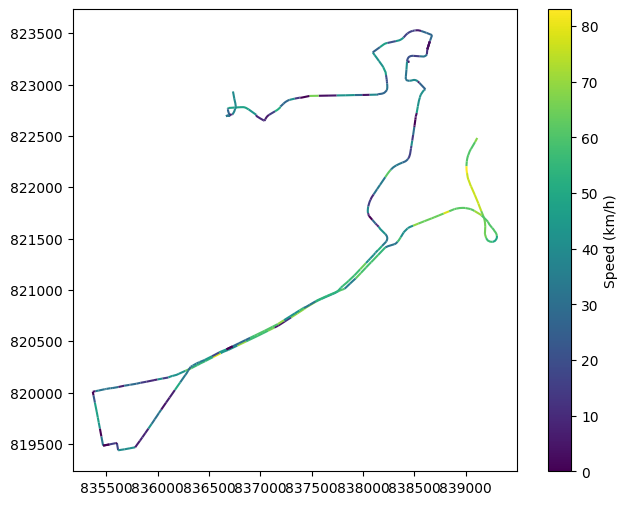

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Adjust the size as needed

# Here we're using 'speed' column to determine the color of each line
result_mean_gdf.plot(column='speed', ax=ax, legend=True,
                     legend_kwds={'label': "Speed (km/h)",
                                  'orientation': "vertical"})